# Выполнил: Филоненко Никита Дмитриевич

-----

# **Домашнее задание 4 (pro): древесные алгоритмы**

### **Постановка задач**

### **Домашнее задание состоит из двух подзадач:**

**1. В  разделе 1 ваша задача:**
-  реализовать свое решающее дерево
- сравнить его со стандартной имплементацией из sklearn

Функции и классы дерева вы должны оформить в модуль `hw4_code_pro.py`.

**2. В разделе два ваша задача:** решить задачу бинарной классификации при помощи написанного Вами дерева, а также леса из sklearn, а после интерпретировать лучшие модели. Чуть точнее

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT, а также RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**
- Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.
- Неэффективная реализация кода может негативно отразиться на оценке.

### **Формат сдачи:**
Задания сдаются через  anytask. Посылка должна содержать:
* Ноутбук в формате ipynb
* Модуль hw4_code_pro.py


### **Баллы:**

Суммарно за задание можно получить 10 основных баллов и 1 бонусный балло.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import psycopg2
import psycopg2.extras

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

import warnings
warnings.filterwarnings('ignore')

# **1. Решающие деревья своими руками (6 баллов)**

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Всего за часть вы можете получить 6 основных баллов и 1 бонусный.

### **Задание 1. (1 балл)**

Реализуйте функцию find_best_split из модуля hw4_code_pro.py

In [ ]:
from hw4_code_pro import find_best_split

### **Задание 2. (0.25 балла)**

Загрузите таблицу [students.csv](https://github.com/AnastasiyaMax/MLDS_ml_course_fall21/blob/main/hw/hw5_trees/students.csv). Это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

В наборе данных:
- признаки объекта записаны в первых пяти столбцах;
- в последнем записана целевая переменная (класс: 0 или 1).

По этим данным, используя функцию из задания 1, постройте:
- пять кривых "порог — значение критерия Джини" для всех пяти признаков;
- scatter-графики "значение признака — класс" для всех пяти признаков;

In [ ]:
data = pd.read_csv("data/students.csv", sep=",")
data

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


In [ ]:
X = data.iloc[:, :5]
y = data.iloc[:, 5]

X.shape, y.shape

((258, 5), (258,))

- Построение кривых "порог — значение критерия Джини

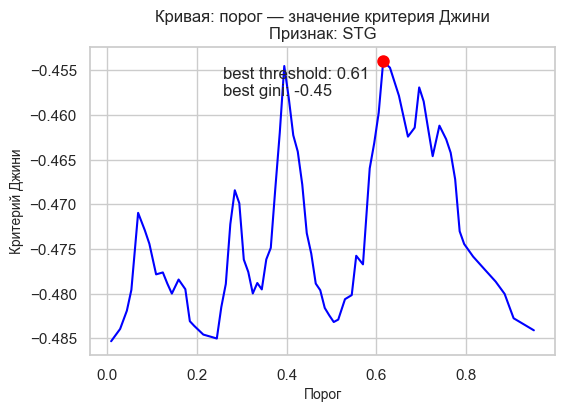

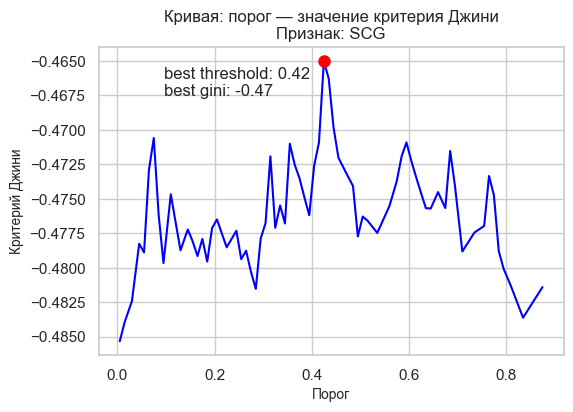

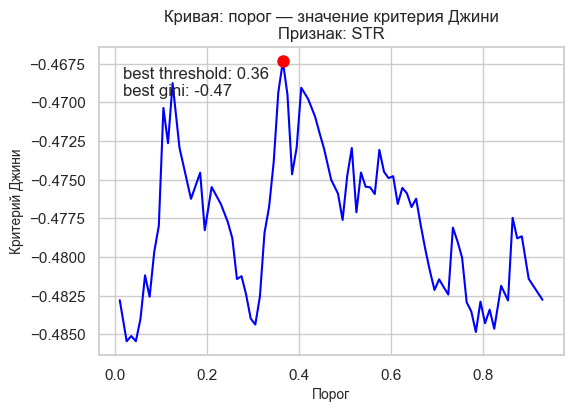

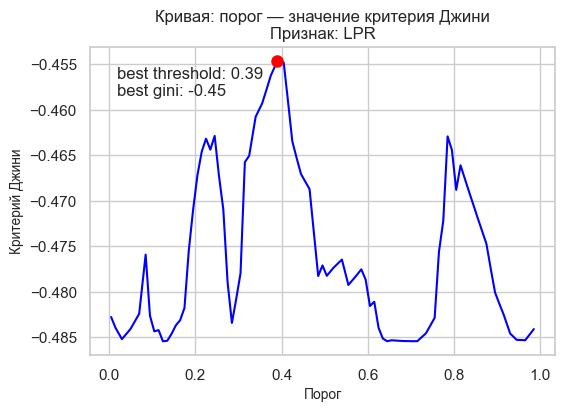

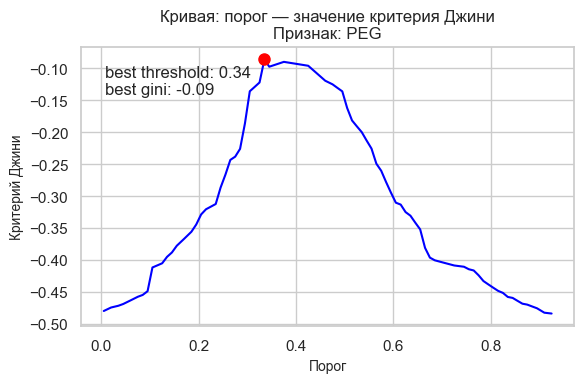

In [ ]:
for feature in X.columns:
    plt.figure(figsize=(6, 4))

    feature_vector = X[feature].values
    target_vector = y.values
    thresholds, ginis, threshold_best, gini_best = find_best_split(feature_vector, target_vector)

    plt.plot(thresholds, ginis, linestyle='-', color='blue')
    plt.title(f"Кривая: порог — значение критерия Джини\nПризнак: {feature}", fontsize=12)
    plt.xlabel("Порог", fontsize=10)
    plt.ylabel("Критерий Джини", fontsize=10)
    plt.grid(True)

    if threshold_best is not None:
        plt.plot(threshold_best, gini_best, marker='o', markersize=8, color='red')
        plt.annotate(f"best threshold: {threshold_best:.2f}\n"
                     f"best gini: {gini_best:.2f}",
                     xy=(threshold_best, gini_best),
                     xytext=(-115,-25), textcoords='offset points', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
for i, col in enumerate(X.columns):
    thresholds, ginis, threshold_best, gini_best = find_best_split(
        feature_vector=X[col].values,
        target_vector=y.values
    )

    print(f"feature: {col}\n"
          f"best gini: {gini_best}\n"
          f"best thresold: {threshold_best}\n\n")

feature: STG
best gini: -0.45397707504410645
best thresold: 0.615


feature: SCG
best gini: -0.4650194980401841
best thresold: 0.425


feature: STR
best gini: -0.46733829445545105
best thresold: 0.365


feature: LPR
best gini: -0.45466831929301205
best thresold: 0.39


feature: PEG
best gini: -0.08606560274912137
best thresold: 0.335


- Построение scatter-графиков "значение признака — класс

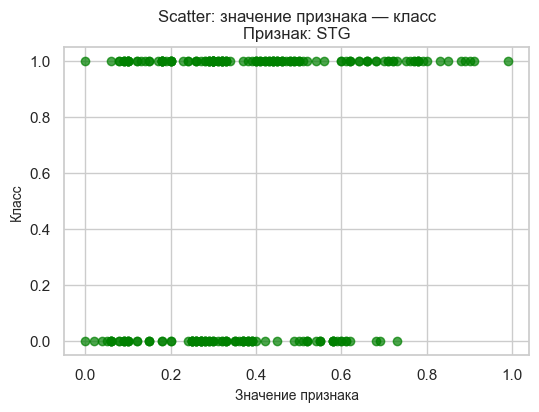

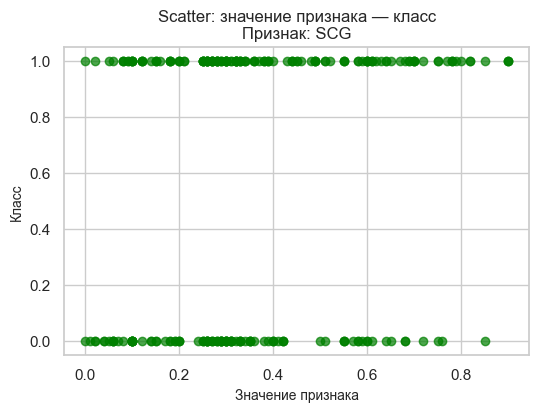

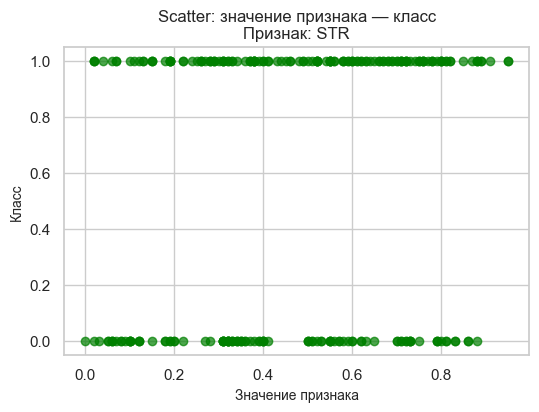

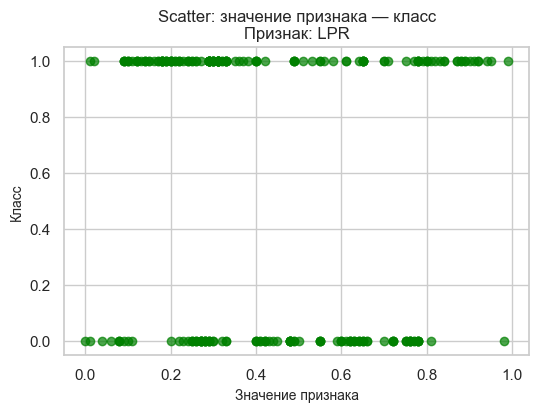

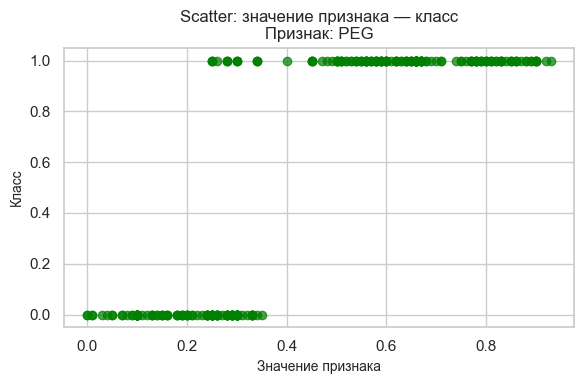

In [ ]:
import matplotlib.pyplot as plt

for feature in X.columns:
    plt.figure(figsize=(6, 4))

    feature_vector = X[feature].values
    target_vector = y.values

    plt.scatter(feature_vector, target_vector, alpha=0.7, color='green')
    plt.title(f"Scatter: значение признака — класс\nПризнак: {feature}", fontsize=12)
    plt.xlabel("Значение признака", fontsize=10)
    plt.ylabel("Класс", fontsize=10)
    plt.grid(True)

plt.tight_layout()
plt.show()

### **Задание 3. (0.6 балла)**

Проанализируйтте построенные кривые. Ответьте на поставленные вопросы:
- По какому признаку нужно производить деление выборки на два поддерева? (0.15 балла)
- Согласуется ли этот результат с визуальной оценкой scatter-графиков? (0.15 балла)
- Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? (0.15 балла)
- Чем отличаются кривые для признаков, по которым деление практически невозможно? (0.15 балла)

**Ответ:**

1. По какому признаку нужно производить деление выборки на два поддерева?

`по признаку PEG достигается наилучшее (с точки зрения выбранного критерия) разделение выборки, поэтому именно по этому признаку следует делить выборку`

`поскольку в задании (в функции find_best_split) для подсчета общего критерия Джини для всего разбиения используется минус, то для лучшего распределения будем максимизировать общий отрицательный Джини (т.е. чем больше общий критерий Джини, тем более гомогенны (однородны) данные относительно целевой переменной) `

2. Согласуется ли этот результат с визуальной оценкой scatter-графиков?

`Да, в сравнении с другими признаками, для признака PEG наблюдается отчетливая граница между объектами разных классов (то есть точки разных классов «сгруппированы» в разных областях значений признака`

3. Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально?

`при переходе через оптимальный порог наблюдается быстрый рост значения критерия (то есть его изменение становится заметным)`

`оптимальный порог выделяется на фоне других значений — именно в его окрестности достигается максимум (в нашем случае максимум близок к нулю, поскольку критерий отрицательный)`

`подытожив, вид кривой для "хороших" признаков, по которым выборка делится почти идеально будет иметь ярко выраженный пик`

4. Чем отличаются кривые для признаков, по которым деление практически невозможно?

`для признаков, которые слабо дискриминируют классы, кривая выглядит почти плоско`

`значения критерия почти не меняются при изменении порога, что говорит о том, что разбиение не влияет существенно на чистоту (гомогенность) подвыборок`

`кривая не демонстрирует резкого скачка – практически любые пороги дают схожий (низкий) эффект по критерию Джини например`

`также могут быть локальные пики, но они нестабильны и не имеют четкой закономерности`

### **Задание 4. (1.15 балла)**

В некоторых случаях необходимо анализировать код исполненного класса на предмет оптимальности и ошибок. Потренируйтесь в этом!

- Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py.
- Найдите ошибки в реализации метода \_fit_node.
- Напишите функцию \_predict_node.

**Примечание 1:**

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева».
- Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Примечание 2:**

- Выбор лучшего разбиения необходимо производить по критерию Джини.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку, чтобы Джини упал
- Ответ в листе: наиболее часто встречающийся класс в листе.


- **Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py**

1. ошибочное условие остановки для терминального узла

условие if `np.all(sub_y != sub_y)` проверяет, все ли элементы отличаются от первого элемента, что противоречит логике

Правильная проверка:

```python
if len(np.unique(sub_y)) == 1:
```

2. пропуск первого признака при переборе

цикл `for feature in range(1, sub_X.shape)` пропускает первый признак

Исправление:

```python
for feature in range(sub_X.shape[1]):
```

3. ошибка в обработке категориальных признаков

`map() в Python 3 возвращает итератор, а не список, поэтому np.array(map(...)) не создаст массив`

правильный вариант:

```python
feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
```

`также тип "Categorical" с заглавной буквы вместо "categorical"`


4. `Проверка len(feature_vector) == 3 не имеет смысла, так как ограничение на минимальное количество элементов обычно задаётся через min_samples_split или min_samples_leaf`

```python
if len(feature_vector) == 3:
    continue
```

5. Ошибка в индексации sub_y при разбиении

В строке:

```python
self._fit_node(sub_X[np.logical_not(split)], sub_y[split], node["right_child"])
```

`Вместо sub_y[split] для правого поддерева нужно sub_y[np.logical_not(split)], иначе у правого поддерева будет неверный набор меток`


6. Ошибка в ratio[key] = current_count / current_click

`Если current_click == 0, произойдет деление на ноль`

`Лучше использовать ratio[key] = current_click / (current_count + 1e-3), чтобы избежать ошибки`


7. Ошибка в выборе класса в терминальном узле

Ошибка:

```python
node["class"] = Counter(sub_y).most_common(1)
```

most_common(1) возвращает список кортежей, например [(1, 5)], а не сам класс

Исправление:

```python
node["class"] = Counter(sub_y).most_common(1)[0][0]
```

Теперь записывается самый частый класс


8. Сортировка категорий по ratio

Ошибка в x[1] — это число, а нужно x[0] (сама категория)

правильная форма:

```python
sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
```

In [ ]:
from hw4_code_pro import DecisionTree

### **Задание 5. (0.5 балла)**

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого:

- Скачайте таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/))
- Прочитайте данные с помощью pandas
- Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
- Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные)
- Сделайте предсказания для оставшейся половины.
- Вычислите accuracy (так как мы используем эту метрику и в силу задачи, нам не очень важно, что будет классом 1, а что — классом 0).  


У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
data_two = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data", delimiter=",")

In [ ]:
data_two

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


- Применим LabelEncoder ко всем столбцам

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in data_two.columns:
    le = LabelEncoder()
    data_two[column] = le.fit_transform(data_two[column])
    label_encoders[column] = le

data_two

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8119,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8120,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8121,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


- В датасете mushrooms первый столбец – класс (edible/poisonous), остальные – признаки

In [ ]:
from sklearn.model_selection import train_test_split

X = data_two.iloc[:, 1:].values
y = data_two.iloc[:, 0].values

feature_types = ["categorical"] * X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tree = DecisionTree(feature_types=feature_types)
tree.fit(X_train, y_train)

y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

y_pred_train.shape, y_pred_test.shape

((6498,), (1625,))

In [ ]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Accuracy Train: {train_acc:.2f}")
print(f"Accuracy Test: {test_acc:.2f}")

Accuracy Train: 1.00
Accuracy Test: 1.00


- также я добавил метод print_node, который будет рекурсивно обходить словарь и выводить структуру дерева в удобочитаемом виде

In [ ]:
tree.print_tree()

Node: feature[4] in [np.int64(4), np.int64(1), np.int64(6), np.int64(8), np.int64(7), np.int64(2)]
├─ Left:
│  Лист: class=1
└─ Right:
   Node: feature[19] in [np.int64(5)]
   ├─ Left:
   │  Лист: class=1
   └─ Right:
      Node: feature[14] in [np.int64(8)]
      ├─ Left:
      │  Лист: class=1
      └─ Right:
         Node: feature[14] in [np.int64(4)]
         ├─ Left:
         │  Node: feature[10] in [np.int64(0)]
         │  ├─ Left:
         │  │  Лист: class=1
         │  └─ Right:
         │     Лист: class=0
         └─ Right:
            Node: feature[1] in [np.int64(1)]
            ├─ Left:
            │  Лист: class=1
            └─ Right:
               Node: feature[0] in [np.int64(1)]
               ├─ Left:
               │  Лист: class=1
               └─ Right:
                  Node: feature[21] in [np.int64(2)]
                  ├─ Left:
                  │  Node: feature[1] in [np.int64(3)]
                  │  ├─ Left:
                  │  │  Лист: class=1
       

### **Задание 6. (бонус, 1 балл)**

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

In [ ]:
df_tic_tac_toe = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data", delimiter=",")

df_tic_tac_toe

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive
2,x,x,x,x,o,o,o,b,b,positive
3,x,x,x,x,o,o,b,o,b,positive
4,x,x,x,x,o,o,b,b,o,positive
...,...,...,...,...,...,...,...,...,...,...
952,o,x,x,x,o,o,o,x,x,negative
953,o,x,o,x,x,o,x,o,x,negative
954,o,x,o,x,o,x,x,o,x,negative
955,o,x,o,o,x,x,x,o,x,negative


In [ ]:
df_tic_tac_toe["positive"].value_counts()

positive
positive    625
negative    332
Name: count, dtype: int64

In [ ]:
label_encoders_tic_tac_toe = {}

for column in df_tic_tac_toe.columns:
    le = LabelEncoder()
    df_tic_tac_toe[column] = le.fit_transform(df_tic_tac_toe[column])
    label_encoders_tic_tac_toe[column] = le

df_tic_tac_toe

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,2,2,2,2,1,1,1,2,1,1
1,2,2,2,2,1,1,1,1,2,1
2,2,2,2,2,1,1,1,0,0,1
3,2,2,2,2,1,1,0,1,0,1
4,2,2,2,2,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
952,1,2,2,2,1,1,1,2,2,0
953,1,2,1,2,2,1,2,1,2,0
954,1,2,1,2,1,2,2,1,2,0
955,1,2,1,1,2,2,2,1,2,0


In [ ]:
from sklearn.model_selection import train_test_split

X = df_tic_tac_toe.iloc[:, :9]
y = df_tic_tac_toe.iloc[:, 9]

feature_types = ["categorical"] * X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((765, 9), (765,), (192, 9), (192,))

In [ ]:
X_train

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3
302,1,2,2,1,2,0,2,1,0
467,1,0,1,1,0,2,2,2,2
294,1,2,2,2,2,1,2,1,1
548,0,1,2,1,0,1,2,2,2
465,1,0,1,2,0,1,2,2,2
...,...,...,...,...,...,...,...,...,...
106,2,2,0,1,2,1,0,2,1
270,2,0,1,0,2,1,0,0,2
860,1,0,2,1,1,2,2,2,1
435,1,0,2,1,2,0,2,2,1


In [ ]:
y_train.value_counts()

positive
1    500
0    265
Name: count, dtype: int64

In [ ]:
X_train, y_train, X_test, y_test = X_train.values, y_train.values, X_test.values, y_test.values

In [ ]:
def evaluate_tree(train_and_test=False, **tree_params):
    tree = DecisionTree(
        feature_types=feature_types,
        **tree_params
    )

    tree.fit(X_train, y_train)

    y_predict_test = tree.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_predict_test)

    if train_and_test:
        y_predict_train = tree.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_predict_train)
        return accuracy_train, accuracy_test

    return accuracy_test

- Исследуем влияние max_depth

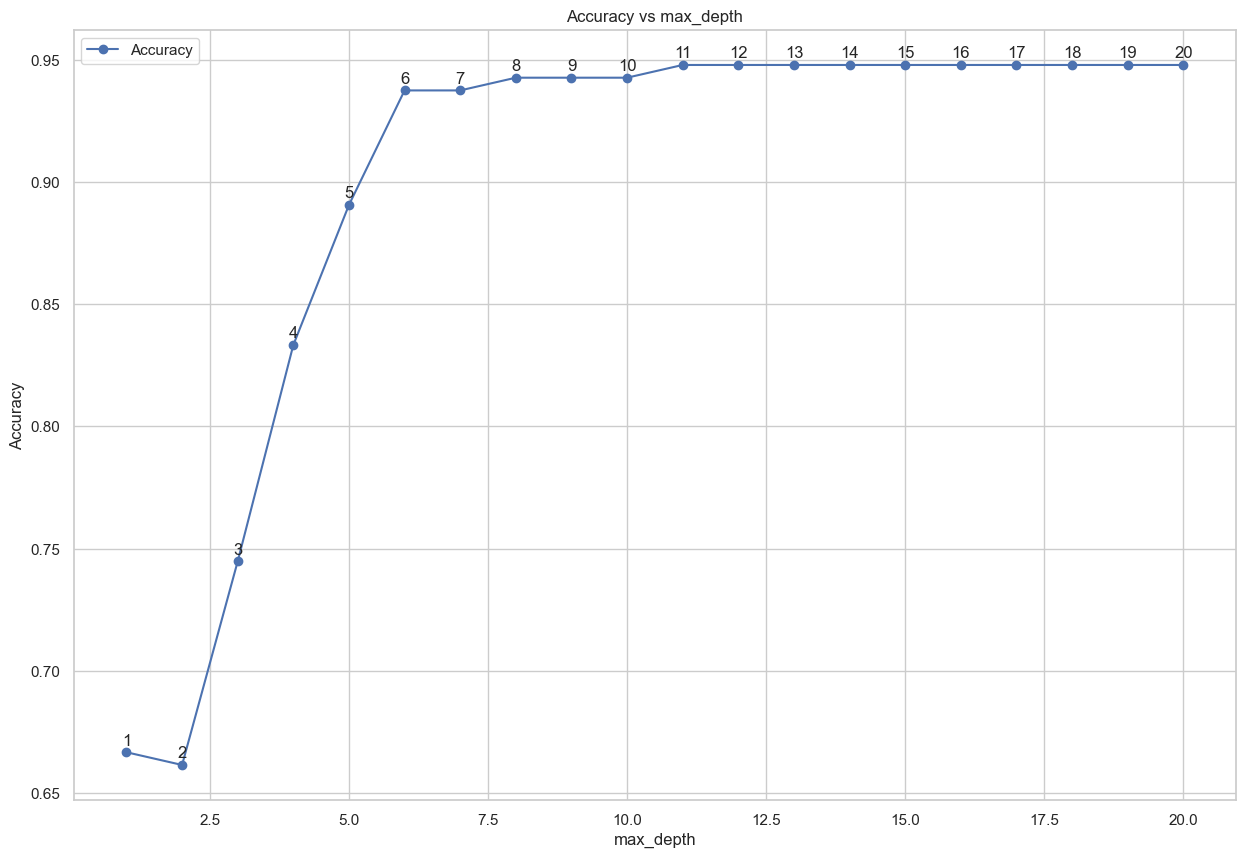

In [ ]:
max_depth_values = list(range(1, 21))
accuracy_max_depth = [evaluate_tree(max_depth=md, min_samples_split=2, min_samples_leaf=1)
                      for md in max_depth_values]

plt.figure(figsize=(15, 10))
plt.plot(max_depth_values, accuracy_max_depth, marker='o', label='Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_depth')
plt.grid(True)
plt.legend()

for x, acc in zip(max_depth_values, accuracy_max_depth):
    plt.annotate(str(x), xy=(x, acc), xytext=(0, 5), textcoords="offset points", ha='center')

plt.show()

- можно заметить, что глубина дерева в 11 уровней является наиболее оптимальной, поскольку:
    - так предсказательная и обобщающая способность модели достигает наилучшего качества в сравнении с более меньшими значениями гиперпараметра
    - также при более большем коэффициенте гиперпараметра max_depth качество модели остается +- прежним, поэтому 11 - лучший выбор

- Исследуем влияние min_samples_split

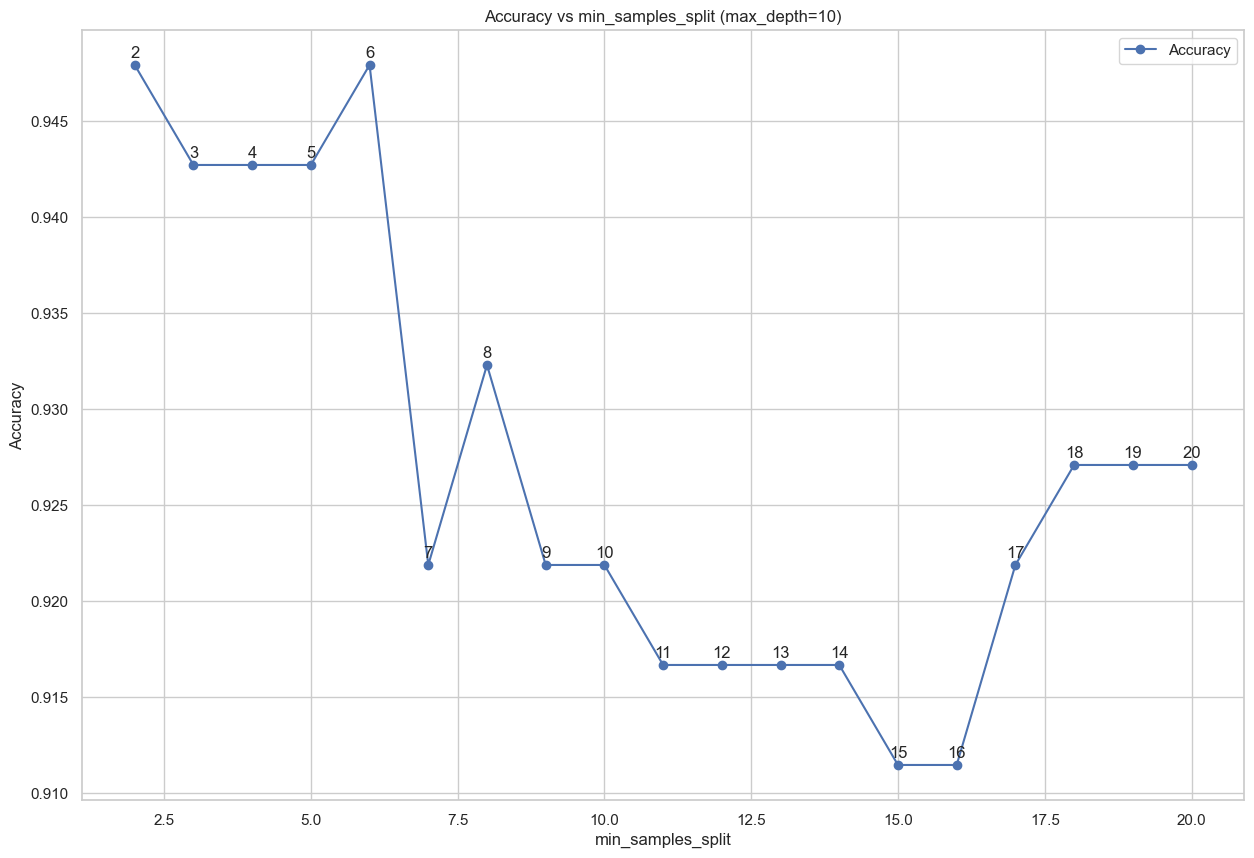

In [ ]:
min_samples_split_values = list(range(2, 21))
accuracy_min_samples_split = [evaluate_tree(max_depth=11, min_samples_split=mss, min_samples_leaf=1)
                              for mss in min_samples_split_values]

plt.figure(figsize=(15, 10))
plt.plot(min_samples_split_values, accuracy_min_samples_split, marker='o', label='Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs min_samples_split (max_depth=10)')
plt.grid(True)
plt.legend()

for x, acc in zip(min_samples_split_values, accuracy_min_samples_split):
    plt.annotate(str(x), xy=(x, acc), xytext=(0, 5), textcoords="offset points", ha='center')

plt.show()

гиперпараметр min_samples_split = 2 наиболее оптимальный

- Исследуем влияние min_samples_leaf

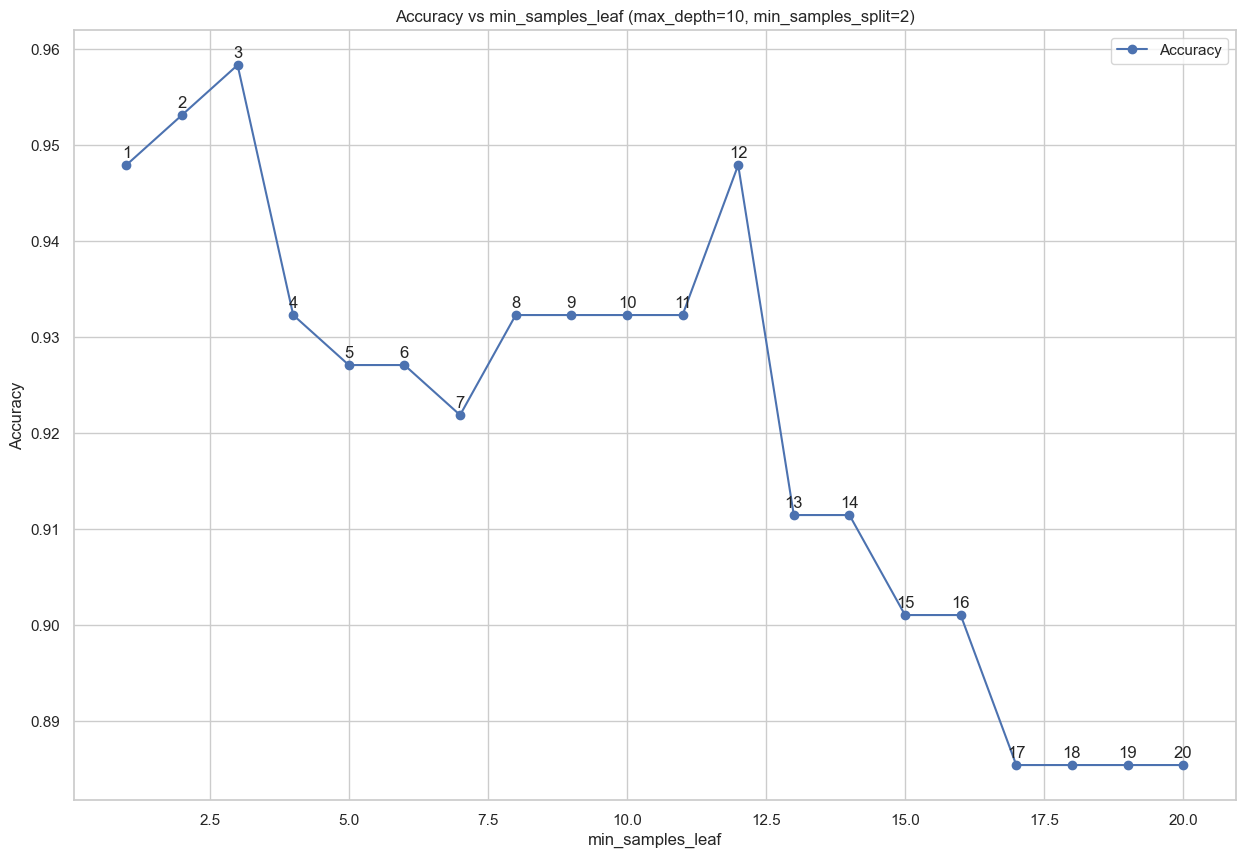

In [ ]:
min_samples_leaf_values = list(range(1, 21))
accuracy_min_samples_leaf = [evaluate_tree(max_depth=11, min_samples_split=2, min_samples_leaf=msl)
                             for msl in min_samples_leaf_values]

plt.figure(figsize=(15, 10))
plt.plot(min_samples_leaf_values, accuracy_min_samples_leaf, marker='o', label='Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy vs min_samples_leaf (max_depth=10, min_samples_split=2)')
plt.grid(True)
plt.legend()

for x, acc in zip(min_samples_leaf_values, accuracy_min_samples_leaf):
    plt.annotate(str(x), xy=(x, acc), xytext=(0, 5), textcoords="offset points", ha='center')

plt.show()

гиперпараметр min_samples_leaf = 3 наиболее оптимальный

- протестируем с подобранными гиперпараметрами

In [ ]:
train_accuracy, test_accuracy = evaluate_tree(
    train_and_test=True,
    max_depth=11,
    min_samples_split=2,
    min_samples_leaf=3
)

print(f"Accuracy Train: {train_accuracy:.2f}")
print(f"Accuracy Test: {test_accuracy:.2f}")

Accuracy Train: 0.98
Accuracy Test: 0.96


### **Задание 7. (2 балла)**

**1. Загрузите следующие наборы данных** (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

**2. Закодируйте категориальные признаки, использовав LabelEncoder.** С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

**Рекомендации:**
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами.

`необходимо расширить класс DecisionTree, добавив методы get_params, set_params, чтобы класс был совместим с scikit-learn`

`это нужно для того, поскольку cross_val_score внутри использует clone() из sklearn.base, который пытается клонировать модель перед обучением. Но clone() требует, чтобы объект поддерживал get_params() и set_params()`

- Функция загрузки данных

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score

def load_and_prepare(url, target_col, class_mapping=None):
    df = pd.read_csv(url, header=None)
    target_col = df.columns[target_col]

    if class_mapping is not None:
        df[target_col] = df[target_col].map(class_mapping)

    le_ = LabelEncoder()
    for col_ in df.columns:
        df[col_] = le_.fit_transform(df[col_])

    X_ = df.drop(columns=[target_col])
    y_ = df[target_col]
    return X_, y_

In [ ]:
datasets = {
    "mushrooms": {
        "url": "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
        "target_col": 0,
        "class_mapping": None
    },
    "tic-tac-toe": {
        "url": "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data",
        "target_col": -1,
        "class_mapping": None
    },
    "cars": {
        "url": "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
        "target_col": -1,
        "class_mapping": {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}
    },
    "nursery": {
        "url": "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data",
        "target_col": -1,
        "class_mapping": {'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1}
    }
}

- Функция для оценки модели через K fold кросс-валидацию (accuracy) -> K = 10

In [ ]:
def evaluate_model(estimator, X, y):
    return np.mean(
        cross_val_score(
            estimator=estimator,
            X=X,
            y=y,
            cv=10,
            scoring=make_scorer(accuracy_score)
        )
    )

In [ ]:
results = {}

for name, params in datasets.items():
    print(f"Обрабатываем {name}...")
    X, y = load_and_prepare(
        url=params["url"],
        target_col=params["target_col"],
        class_mapping=params["class_mapping"]
    )

    X_np = X.values
    y_np = y.values

    onehot = OneHotEncoder(sparse_output=False)
    X_onehot = onehot.fit_transform(X)

    # 1. DecisionTree (real features)
    dt_real = DecisionTree(feature_types=["real"] * X.shape[1])
    # 2. DecisionTree (categorical features)
    dt_cat = DecisionTree(feature_types=["categorical"] * X.shape[1])
    # 3. DecisionTree (real + one-hot)
    dt_onehot = DecisionTree(feature_types=["real"] * X_onehot.shape[1])
    # 4. sklearn DecisionTreeClassifier
    dt_sklearn = DecisionTreeClassifier()

    score_dt_real = evaluate_model(
        estimator=dt_real,
        X=X_np,
        y=y_np
    )

    score_dt_cat = evaluate_model(
        estimator=dt_cat,
        X=X_np,
        y=y_np
    )

    score_dt_onehot = evaluate_model(
        estimator=dt_onehot,
        X=X_onehot,
        y=y_np
    )

    score_dt_sklearn = evaluate_model(
        estimator=dt_sklearn,
        X=X_np,
        y=y_np
    )

    results[name] = {
        "DecisionTree (real features)": score_dt_real,
        "DecisionTree (categorical features)": score_dt_cat,
        "DecisionTree (one-hot features)": score_dt_onehot,
        "DecisionTreeClassifier (sklearn)": score_dt_sklearn
    }

Обрабатываем mushrooms...
Обрабатываем tic-tac-toe...
Обрабатываем cars...
Обрабатываем nursery...


- Собираем результаты в DataFrame (строки — датасеты, столбцы — модели)

In [ ]:
results_df = pd.DataFrame(results).T

results_df

,DecisionTree (real features),DecisionTree (categorical features),DecisionTree (one-hot features),DecisionTreeClassifier (sklearn)
mushrooms,0.999261,1.000000,0.999631,0.960384
tic-tac-toe,0.467533,0.549825,0.543575,0.755022
cars,0.942647,0.965234,0.919495,0.942707
nursery,0.999691,0.999537,0.999537,0.999691


### **Задание 8. (0.5 балла)**

Проанализируйте результаты эксперимента. Ответьте на вопросы:
- Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.
- Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
- Если случайность есть, то можно ли повлиять на нее и улушить работу алгоритмов?

In [ ]:
for name, params in datasets.items():
    temp_df = pd.read_csv(params["url"], header=None)
    print("\n\nDataset", name)
    print(temp_df)
    print()



Dataset mushrooms
     0  1  2  3  4  5  6  7  8  9   ... 13 14 15 16 17 18 19 20 21 22
0     p  x  s  n  t  p  f  c  n  k  ...  s  w  w  p  w  o  p  k  s  u
1     e  x  s  y  t  a  f  c  b  k  ...  s  w  w  p  w  o  p  n  n  g
2     e  b  s  w  t  l  f  c  b  n  ...  s  w  w  p  w  o  p  n  n  m
3     p  x  y  w  t  p  f  c  n  n  ...  s  w  w  p  w  o  p  k  s  u
4     e  x  s  g  f  n  f  w  b  k  ...  s  w  w  p  w  o  e  n  a  g
...  .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
8119  e  k  s  n  f  n  a  c  b  y  ...  s  o  o  p  o  o  p  b  c  l
8120  e  x  s  n  f  n  a  c  b  y  ...  s  o  o  p  n  o  p  b  v  l
8121  e  f  s  n  f  n  a  c  b  n  ...  s  o  o  p  o  o  p  b  c  l
8122  p  k  y  n  f  y  f  c  n  b  ...  k  w  w  p  w  o  e  w  v  l
8123  e  x  s  n  f  n  a  c  b  y  ...  s  o  o  p  o  o  p  o  c  l

[8124 rows x 23 columns]


Dataset tic-tac-toe
     0  1  2  3  4  5  6  7  8         9
0    x  x  x  x  o  o  x  o  o  positive
1    x  x 

**Ответ:**

1. Одинаково ли для разных наборов данных ранжируются алгоритмы? Почему так происходит?

`Нет, ранжирование алгоритмов различается в зависимости от набора данных`

Mushrooms и Nursery:

`Здесь наши реализации DecisionTree (независимо от способа кодирования признаков) почти идеально классифицируют объекты (accuracy около 0.999–1.000), тогда как стандартный DecisionTreeClassifier из sklearn показывает чуть более низкое качество (около 0.956–0.999)`

`Это может быть связано с тем, что в этих датасетах признаки хорошо разделяют классы, а особенности реализации нашего дерева (например, выбор порога и критерий Джини) позволяют добиться почти полного разделения, особенно если признаки обрабатываются как категориальные`

Cars:

`В этом наборе наблюдается, что DecisionTree, считающий признаки категориальными, показывает наилучший результат (0.965), а остальные варианты – несколько ниже (0.942–0.919)`

Tic-tac-toe:

`Здесь ситуация обратная – наши реализации (считающие признаки как real или categorical, а также вариант с one-hot) дают довольно низкие результаты (от 0.467 до 0.550)`

`тогда как стандартный DecisionTreeClassifier показывает значительно более высокое качество (0.747)`

`Это может быть связано с тем, что в датасете Tic-Tac-Toe классы разделяются не так просто, а наши критерии разбиения и способ кодирования категориальных признаков не передают всю информативность признаков`

`Вероятно реализация sklearn более оптимизирована для таких задач`

Почему так происходит?

- Природа данных
- One-hot кодирование увеличивает размерность данных, что может приводить к переобучению (как в cars) или потере информации о взаимосвязях между категориями
- sklearn более оптимизирована для таких задач


2. Присутствует ли в результатах какая-то компонента случайности?

`Компонента случайности присутствует, но она минимальна`

- `В tic-tac-toe данные представляют собой комбинации крестиков и ноликов, и их порядок может влиять на разбиение в дереве решений`
- `В mushrooms и cars данные категориальные, и их порядок также может влиять на результат, но из-за высокой однородности данных это влияние незначительно`
- `В nursery данные также категориальные, и их структура позволяет достичь высокой точности без сильного влияния случайности`


3.  Если случайность есть, то можно ли повлиять на нее и улучшить работу алгоритмов?

`Да, на случайность можно повлиять и улучшить работу алгоритмов`

- Установка фиксированного значения random_state в DecisionTree
- Запуск алгоритма несколько раз с разными random seed и усреднение результатов
- Подбор оптимальных значений гиперпараметров (например, max_depth, min_samples_split, min_samples_leaf) с помощью GridSearch или RandomizedSearch

# **2. Задача бинарной классификации реализованным деревом (4 балла)**

Всего за эту часть можно получить 4 балла.

В этом разделе вам необходимо решить задачу бинарной классификации самописным деревом и лесом из sklearn, а после интерпретировать лучшие модели. А именно:

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT и RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Познакомимся с задачей: постановка**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Задание 9. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

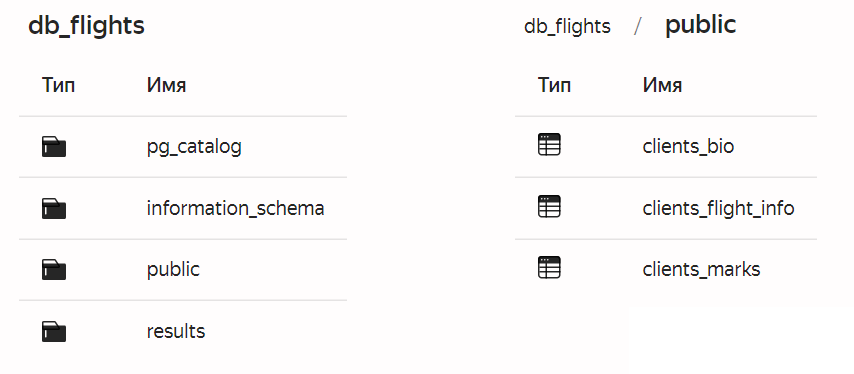

In [ ]:
DB_PARAMS = {
    "host": "rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    "port": 6432,
    "dbname": "db_flights",
    "user": "mlhs_student",
    "password": "mlhs_student",
    "sslmode": "verify-full"
}

In [ ]:
query = """
    SELECT *
    FROM public.clients_bio
    INNER JOIN public.clients_flight_info USING (id)
    INNER JOIN public.clients_marks USING (id)
"""

with psycopg2.connect(**DB_PARAMS) as conn:
    df = pd.read_sql_query(query, conn)
    df.set_index('id', inplace=True)

In [ ]:
df

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129838,Female,59.0,Loyal Customer,Personal Travel,Eco,308.0,32.0,24.0,3.0,5.0,...,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,neutral or dissatisfied
129839,Male,61.0,Loyal Customer,Personal Travel,Eco,337.0,0.0,0.0,2.0,4.0,...,2.0,3.0,3.0,4.0,5.0,5.0,5.0,4.0,3.0,neutral or dissatisfied
129846,Male,44.0,Loyal Customer,Personal Travel,Eco,447.0,0.0,0.0,2.0,5.0,...,2.0,5.0,5.0,4.0,2.0,4.0,3.0,4.0,5.0,neutral or dissatisfied


In [ ]:
assert df.shape == (129_549, 23)

In [ ]:
df.to_csv("df_public.csv", index=True)

In [ ]:
df = pd.read_csv("data/df_public.csv", delimiter=",")
df.set_index('id', inplace=True)
df

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129838,Female,59.0,Loyal Customer,Personal Travel,Eco,308.0,32.0,24.0,3.0,5.0,...,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,neutral or dissatisfied
129839,Male,61.0,Loyal Customer,Personal Travel,Eco,337.0,0.0,0.0,2.0,4.0,...,2.0,3.0,3.0,4.0,5.0,5.0,5.0,4.0,3.0,neutral or dissatisfied
129846,Male,44.0,Loyal Customer,Personal Travel,Eco,447.0,0.0,0.0,2.0,5.0,...,2.0,5.0,5.0,4.0,2.0,4.0,3.0,4.0,5.0,neutral or dissatisfied


In [ ]:
assert df.shape == (129_549, 23)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [ ]:
df_train = df[df.satisfaction != '-']

df_train.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied


In [ ]:
assert df_train.shape == (103_644, 23)

In [ ]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
55,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0


In [ ]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [ ]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 10 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)
- Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.
- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

- Определяем числовые столбцы

In [ ]:
num_cols = X_train.select_dtypes(include=['number']).columns
num_cols

Index(['age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness'],
      dtype='object')

- Преобразуем их в float

In [ ]:
X_train[num_cols] = X_train[num_cols].astype(float)
X_val[num_cols] = X_val[num_cols].astype(float)

- Проверим выбросы (в том числе в категориальных признаках)

Поиск выбросов в числовых данных

Выбросы можно обнаружить с помощью "правила трех сигм" или межквартильного размаха (IQR)

Будем использовать IQR

In [ ]:
from colorama import Fore, Style

for col in num_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X_train[(X_train[col] < lower_bound) | (X_train[col] > upper_bound)]

    print(f"{Fore.GREEN}{col}{Style.RESET_ALL}: найдено {Fore.RED}{len(outliers)}{Style.RESET_ALL} выбросов\n")

age: найдено 250 выбросов

Flight Distance: найдено 1688 выбросов

Departure Delay in Minutes: найдено 9710 выбросов

Arrival Delay in Minutes: найдено 9860 выбросов

Inflight wifi service: найдено 13 выбросов

Departure/Arrival time convenient: найдено 15 выбросов

Ease of Online booking: найдено 16 выбросов

Gate location: найдено 23 выбросов

Food and drink: найдено 11 выбросов

Online boarding: найдено 14 выбросов

Seat comfort: найдено 12 выбросов

Inflight entertainment: найдено 13 выбросов

On-board service: найдено 13 выбросов

Leg room service: найдено 19 выбросов

Baggage handling: найдено 15 выбросов

Checkin service: найдено 9030 выбросов

Inflight service: найдено 21 выбросов

cleanliness: найдено 14 выбросов


Проверка выбросов в категориальных признаках

Для категориальных данных выбросы — это редкие или аномальные значения

In [ ]:
cat_cols = X_train.select_dtypes(include=['object']).columns

for col in cat_cols:
    print(f"\nСтолбец: {Fore.RED}{col}{Style.RESET_ALL}")
    print('-' * 25)
    print(X_train[col].value_counts(normalize=True) * 100)


Столбец: gender
-------------------------
gender
Female    50.745693
Male      49.254307
Name: proportion, dtype: float64

Столбец: Customer Type
-------------------------
Customer Type
Loyal Customer       81.869845
disloyal Customer    18.130155
Name: proportion, dtype: float64

Столбец: Type of Travel
-------------------------
Type of Travel
Business travel    68.962472
Personal Travel    31.037528
Name: proportion, dtype: float64

Столбец: class
-------------------------
class
Business    47.909884
Eco         44.900944
Eco Plus     7.189173
Name: proportion, dtype: float64


gender -> равномерное распределение, выбросов нет
Customer Type -> Баланс неравномерный, но выбросов нет
Type of Travel -> Баланс неравномерный, но выбросов нет
class ->  "Eco Plus" встречается редко (7.19%)

Но это не выброс, так как такой класс реально существует

`Нет явных выбросов в категориальных признаках`

`Деревья решений не чувствительны к масштабу данных и могут хорошо работать с редкими категориями, если они действительно значимы`

`Но все же слишком редкие категории могут привести к переобучению, если в данных мало примеров для обучения`

- Проверяем NaN только в X_train и X_val

In [ ]:
print("Пропущенные значения в X_train:")
X_train.isnull().sum()[X_train.isnull().sum() > 0]

Пропущенные значения в X_train:


age                                  185
Customer Type                         52
Type of Travel                        70
class                                 66
Flight Distance                       54
Departure Delay in Minutes            61
Arrival Delay in Minutes             294
Inflight wifi service                 23
Departure/Arrival time convenient     28
Ease of Online booking                24
Gate location                         19
Food and drink                        22
Online boarding                       23
Seat comfort                          23
Inflight entertainment                30
On-board service                      23
Leg room service                      22
Baggage handling                      21
Checkin service                       22
Inflight service                      30
cleanliness                           21
dtype: int64

In [ ]:
print("Пропущенные значения в X_val:")
X_val.isnull().sum()[X_val.isnull().sum() > 0]

Пропущенные значения в X_val:


age                                   76
Customer Type                         14
Type of Travel                        18
class                                 23
Flight Distance                       18
Departure Delay in Minutes            23
Arrival Delay in Minutes             111
Inflight wifi service                  9
Departure/Arrival time convenient     13
Ease of Online booking                 9
Gate location                         11
Food and drink                        13
Online boarding                       14
Seat comfort                          18
Inflight entertainment                12
On-board service                       9
Leg room service                      14
Baggage handling                      11
Checkin service                       12
Inflight service                      19
cleanliness                           10
dtype: int64

пропуски есть, переходим к их заполнению

- Заполнение пропусков модой (наиболее частым значением)

- Заполняем числовые пропуски медианой из X_train

In [ ]:
for col in num_cols:
    median_value = X_train[col].median()
    X_train[col].fillna(median_value, inplace=True)
    X_val[col].fillna(median_value, inplace=True)

- Заполняем категориальные пропуски модой из X_train

In [ ]:
for col in cat_cols:
    mode_value = X_train[col].mode()[0]
    X_train[col].fillna(mode_value, inplace=True)
    X_val[col].fillna(mode_value, inplace=True)

In [ ]:
print(f"Пропущенные значения в X_train: {Fore.GREEN}{X_train.isnull().sum().sum()}{Style.RESET_ALL}")

Пропущенные значения в X_train: 0


In [ ]:
print(f"Пропущенные значения в X_val: {Fore.GREEN}{X_val.isnull().sum().sum()}{Style.RESET_ALL}")

Пропущенные значения в X_val: 0


- выведем описательные статистики для числовых и категориальных признаков

- числовые:

In [ ]:
X_train.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000
mean,40.101406,1329.395700,15.859366,16.645968,2.733687,3.064631,2.761006,2.982688,3.209014,3.256196,3.445665,3.362150,3.383101,3.352364,3.630255,3.308753,3.640234,3.290889
std,20.658121,4764.310846,70.861937,97.990293,1.362172,1.552146,1.414843,1.316648,1.349898,1.372683,1.346077,1.360862,1.333758,1.360180,1.227853,1.293069,1.215114,1.343257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,413.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,544.000000,379620.000000,9282.000000,11760.000000,45.000000,45.000000,28.000000,36.000000,36.000000,32.000000,45.000000,40.000000,45.000000,36.000000,40.000000,45.000000,36.000000,45.000000


In [ ]:
X_val.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000,31094.000000
mean,39.958223,1316.762977,15.666945,16.871776,2.732521,3.064418,2.758989,2.978195,3.194796,3.252139,3.438477,3.359265,3.394578,3.367756,3.648775,3.306522,3.655303,3.286454
std,19.549434,4378.955003,80.658377,131.103562,1.348038,1.558453,1.439010,1.290490,1.358835,1.414546,1.356474,1.358533,1.337013,1.379536,1.224217,1.321815,1.204409,1.345305
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,27.000000,417.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,845.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,612.000000,255522.000000,11011.000000,14006.000000,40.000000,35.000000,45.000000,32.000000,45.000000,40.000000,36.000000,36.000000,40.000000,40.000000,40.000000,45.000000,35.000000,40.000000


- категориальные

In [ ]:
X_train.describe(include='object')

,gender,Customer Type,Type of Travel,class
count,72550,72550,72550,72550
unique,2,2,2,3
top,Female,Loyal Customer,Business travel,Business
freq,36816,59406,50054,34793


In [ ]:
X_val.describe(include='object')

,gender,Customer Type,Type of Travel,class
count,31094,31094,31094,31094
unique,2,2,2,3
top,Female,Loyal Customer,Business travel,Business
freq,15774,25315,21457,14783


#### **текстовый** вывод о распределениях значений признаков

**Числовые признаки**

`age: Средний возраст пассажиров ≈ 40 лет, но есть выбросы (максимум 544 и 612 лет в X_train и X_val соответственно)`

`Flight Distance: Среднее ≈ 1300, но большой разброс (максимум до 379620 в X_train и 255522 в X_val). Возможно, есть выбросы`

`Departure Delay in Minutes, Arrival Delay in Minutes: Большинство значений равно 0 (50-й перцентиль). Максимальные задержки достигают 11 000–14 000 минут, что указывает на сильные выбросы`

`Inflight wifi service, Food and drink, Online boarding, и т. д.: Средние значения — около 3–4, что указывает на преобладание средних оценок, однако  есть аномально большие значения (максимум 40–45)`


**Категориальные признаки**

`gender: Распределение почти равномерное (≈ 50% женщин и 50% мужчин)`

`Customer Type: ≈ 82% — лояльные клиенты, только 18% — новые. Может привести к дисбалансу классов`

`Type of Travel: 69% — бизнес-поездки, 31% — личные`

`class: Business — 48%, Eco — 45%, Eco Plus — 7%`


Стоит нормализовать выбросы и учитывать дисбаланс при построении модели

### **Задание 11. (2 балла)**

Осуществите предобработку датасета для обучения **полностью самостоятельно**, на основе вашего опыта из прошлых дз и изученной теории. Обязательно **комментируйте** каждое действие.

**Примечание:**

В данном задании ваша задача в том числе убедить ревьюера в достаточности предобработки.

#### Предобработка данных для обучения Decision Tree и Random Forest

1. Представление категориальных признаков

**Категориальные признаки:**

gender (Male/Female)

Customer Type (Loyal/disloyal Customer)

Type of Travel (Business/Personal)

class (Business/Eco/Eco Plus)

Действия:

- **Label Encoding** для признаков gender, Customer Type, Type of Travel

- Для признака class (3 категории) **Ordinal Encoding** для сохранения естественного порядка
    - Eco → 0, Eco Plus → 1, Business → 2

In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

binary_cols = ['gender', 'Customer Type', 'Type of Travel']
le_ = LabelEncoder()
for col in binary_cols:
    X_train[col] = le_.fit_transform(X_train[col])
    X_val[col] = le_.transform(X_val[col])

class_order = [['Eco', 'Eco Plus', 'Business']]
oe = OrdinalEncoder(categories=class_order)
X_train['class'] = oe.fit_transform(X_train[['class']])
X_val['class'] = oe.transform(X_val[['class']])

In [ ]:
X_train[['gender', 'Customer Type', 'Type of Travel']] = X_train[['gender', 'Customer Type', 'Type of Travel']].astype(float)

In [ ]:
X_train['class']

id
2031      2.0
11597     2.0
74668     0.0
31602     0.0
51518     0.0
         ... 
63360     0.0
29678     1.0
118743    0.0
8922      0.0
28513     0.0
Name: class, Length: 72550, dtype: float64

#### 2. Обработка выбросов

Выявленные проблемы:

age: значения > 100 лет (например, 544 и 612 лет) — явные аномалии.

Flight Distance: значения > 5000 км (например, 379620 км) — ошибки в данных

Departure/Arrival Delay in Minutes: значения > 1000 минут (16 часов) — редкие, но возможные случаи

Inflight wifi service, Food and drink и др.: значения > 5 (максимальная оценка) — ошибки

Действия:

Для возраста: замена значений > 100 на медиану (~40 лет). Поскольку, например, 544 и 612 лет явные аномалии, а медиана устойчива к выбросам и лучше отражает типичный возраст пассажиров

Для расстояния полета: замена значений > 5000 км на 99-й перцентиль. Это значение близко к реальному максимуму, но исключает явные ошибки

Для задержек: замена значений > 1000 минут на 95-й перцентиль. Задержки > 1000 минут (16 часов) редки и могут быть ошибками. Замена на 95-й перцентиль сохраняет реальные задержки, но устраняет аномалии

Для оценок: замена значений > 5 на 5. Поскольку оценки > 5 (максимальная оценка) — ошибки. Замена на 5 сохраняет шкалу оценок

- Обработка возраста

In [ ]:
age_median = X_train['age'].median()
X_train['age'] = X_train['age'].apply(lambda x: age_median if x > 100 else x)
X_val['age'] = X_val['age'].apply(lambda x: age_median if x > 100 else x)

- Обработка Flight Distance

In [ ]:
flight_distance_p99 = X_train['Flight Distance'].quantile(0.99)
X_train['Flight Distance'] = X_train['Flight Distance'].apply(lambda x: flight_distance_p99 if x > 5000 else x)
X_val['Flight Distance'] = X_val['Flight Distance'].apply(lambda x: flight_distance_p99 if x > 5000 else x)

- Обработка задержек

In [ ]:
delay_p95 = X_train['Departure Delay in Minutes'].quantile(0.95)
for col in ['Departure Delay in Minutes', 'Arrival Delay in Minutes']:
    X_train[col] = X_train[col].apply(lambda x: delay_p95 if x > 1000 else x)
    X_val[col] = X_val[col].apply(lambda x: delay_p95 if x > 1000 else x)

- Обработка оценок

In [ ]:
rating_cols = ['Inflight wifi service', 'Departure/Arrival time convenient',
               'Food and drink', 'Online boarding', 'Seat comfort',
               'Inflight entertainment', 'On-board service', 'Leg room service',
               'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness']

for col in rating_cols:
    X_train[col] = X_train[col].apply(lambda x: 5 if x > 5 else x)
    X_val[col] = X_val[col].apply(lambda x: 5 if x > 5 else x)

- Проверка пропусков

In [ ]:
print(X_train.isnull().sum().sum())
print(X_val.isnull().sum().sum())

0
0


- Проверим также полные дубликаты

In [ ]:
X_train.

#### Масштабирование данных

Decision Tree и Random Forest не требуют масштабирования признаков, так как работают с порядком значений, а не с их абсолютной величиной

Поэтому StandardScaler или MinMaxScaler не применяем

- Итоговый набор данных

In [ ]:
X_train

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
2031,0.0,29.0,1.0,0.0,2.0,785.0,0.0,0.0,2.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,5.0,4.0,5.0,4.0
11597,0.0,45.0,0.0,0.0,2.0,3269.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,3.0,3.0,3.0,3.0,5.0,3.0,1.0
74668,1.0,8.0,0.0,1.0,0.0,1431.0,0.0,0.0,3.0,1.0,...,5.0,3.0,5.0,5.0,2.0,5.0,2.0,2.0,1.0,5.0
31602,0.0,48.0,0.0,1.0,0.0,602.0,0.0,0.0,4.0,5.0,...,2.0,5.0,4.0,4.0,4.0,4.0,2.0,3.0,4.0,3.0
51518,0.0,25.0,1.0,0.0,0.0,651.0,0.0,0.0,5.0,0.0,...,2.0,5.0,2.0,2.0,1.0,1.0,2.0,3.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63360,0.0,25.0,0.0,1.0,0.0,337.0,0.0,0.0,1.0,4.0,...,4.0,1.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0
29678,1.0,77.0,0.0,0.0,1.0,1448.0,0.0,0.0,2.0,5.0,...,2.0,2.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,2.0
118743,0.0,31.0,0.0,1.0,0.0,304.0,21.0,12.0,4.0,4.0,...,1.0,4.0,5.0,1.0,5.0,3.0,5.0,4.0,5.0,1.0


#### проверим также таргет

пропуски

In [ ]:
print(y_train.isnull().sum())
print(y_val.isnull().sum())

0
0


Проверка дубликатов

In [ ]:
print(f"Количество дубликатов в X_train: {X_train.duplicated().sum()}")
print(f"Количество дубликатов в X_val: {X_val.duplicated().sum()}")

Количество дубликатов в X_train: 0
Количество дубликатов в X_val: 0


- также закодируем таргеты

In [ ]:
y_train.unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

In [ ]:
y_val.unique()

array(['satisfied', 'neutral or dissatisfied'], dtype=object)

In [ ]:
y_train = y_train.map(
    {
        'satisfied': 1,
        'neutral or dissatisfied': 0
    }
)

y_val = y_val.map(
    {
        'satisfied': 1,
        'neutral or dissatisfied': 0
    }
)

y_train

id
2031      0
11597     1
74668     0
31602     0
51518     1
         ..
63360     0
29678     0
118743    0
8922      1
28513     0
Name: satisfaction, Length: 72550, dtype: int64

### **Задание 12. (0.25 балла)**

- Обучите самописное дерево и Random Forest с базовыми гиперпараметрами. Выведите `f1-score`.

In [ ]:
X_train.dtypes.unique()

array([dtype('float64')], dtype=object)

In [ ]:
type(X_train.values)

numpy.ndarray

- Custom DT

In [ ]:
feature_types = []
for col in X_train.columns:
    if col in cat_cols:
        feature_types.append('categorical')
    else:
        feature_types.append('real')

In [ ]:
from sklearn.metrics import f1_score

tree_custom = DecisionTree(
    feature_types=feature_types
)

tree_custom.fit(X=X_train.values, y=y_train.values)

y_train_pred_custom = tree_custom.predict(X_train.values)
y_val_pred_custom = tree_custom.predict(X_val.values)

f1_train_custom = f1_score(y_train, y_train_pred_custom, average='weighted')
f1_val_custom = f1_score(y_val, y_val_pred_custom, average='weighted')

print("Custom Decision Tree")
print(f"f1 train: {f1_train_custom:.2f}\n"
      f"f1 validation: {f1_val_custom:.2f}")

Custom Decision Tree
f1 train: 1.00
f1 validation: 0.94


- Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    random_state=42
)

rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

f1_train = f1_score(y_train, y_train_pred, average='weighted')
f1_val = f1_score(y_val, y_val_pred, average='weighted')

print("Random Forest")
print(f"f1 train: {f1_train:.2f}\n"
      f"f1 validation: {f1_val:.2f}")

Random Forest
f1 train: 1.00
f1 validation: 0.96


### **Задание 13. (0.4 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса и дерева (если реализовали их в бонусе), используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Сравните качество полученных моделей и выберите лучшую. Лучшую модель сохраните в pickle.

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

- Random Forest

In [ ]:
from scipy.stats import uniform, randint


param_dist_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini'],
    'max_samples': uniform(0.6, 0.3)
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestClassifier(random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("Лучшие параметры для Random Forest:", rf_search.best_params_)

best_rf = rf_search.best_estimator_
y_val_pred_rf = rf_search.predict(X_val)
f1_val_rf = f1_score(y_val, y_val_pred_rf, average='weighted')
print(f"F1-score для Random Forest на валидационной выборке: {f1_val_rf:.4f}")

Лучшие параметры для Random Forest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': np.float64(0.8406590942262119), 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
F1-score для Random Forest на валидационной выборке: 0.9613


- Custom DT

In [ ]:
param_dist_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'criterion': ['gini']
}

In [ ]:
dt_model = DecisionTree(
    feature_types=feature_types,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)

dt_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist_dt,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    random_state=42,
    n_jobs=-1
)

dt_search.fit(X_train.values, y_train.values)

print("Лучшие параметры для Decision Tree:", dt_search.best_params_)

best_dt = dt_search.best_estimator_
y_val_pred_dt = dt_search.predict(X_val.values)
f1_val_dt = f1_score(y_val, y_val_pred_dt, average='weighted')
print(f"F1-score для Decision Tree на валидационной выборке: {f1_val_dt:.4f}")

Лучшие параметры для Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 6}
F1-score для Decision Tree на валидационной выборке: 0.9421


### **Задание 14. Анализ моделей (0.1 балла)**

- Отобразите`feature_importances_` вашего лучшего случайного леса;
- Проанализируйте, какие признаки оказались важными?

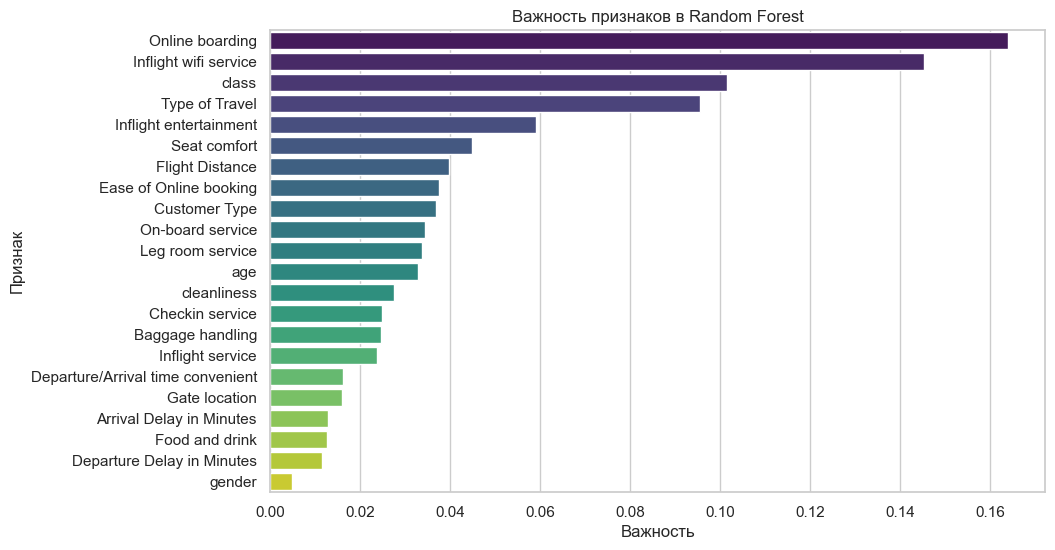

In [ ]:
feature_importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков в Random Forest')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

- Наиболее важные признаки:

In [ ]:
importance_df[:5]

,Feature,Importance
13,Online boarding,0.164003
8,Inflight wifi service,0.145384
4,class,0.101406
3,Type of Travel,0.095487
15,Inflight entertainment,0.059033


### **Задание 15. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

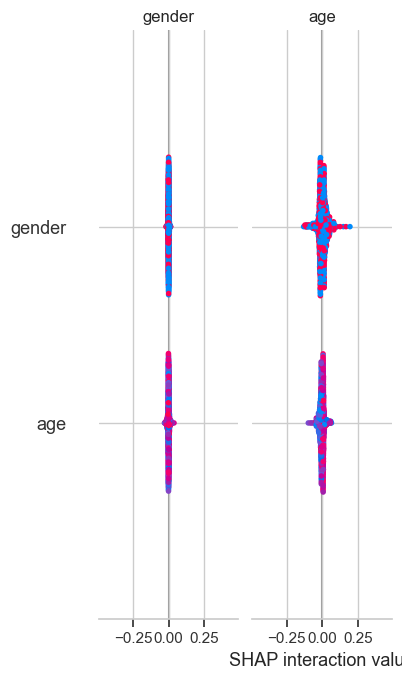

In [ ]:
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train.iloc[:1000])

shap.summary_plot(shap_values, X_train.iloc[:1000], plot_type="bar")

Что видно на графике?

Горизонтальная ось — SHAP interaction values:

`показывает, насколько сильно взаимодействие между признаками влияет на предсказания модели`

`значения близкие к 0 означают слабое влияние, а отклонение влево или вправо говорит о значительном влиянии`

Вертикальная ось — признаки (gender и age), взаимодействие между которыми анализируется

Мы видим два основных взаимодействия

`gender - gender (влияние самого признака gender)`

`age - gender (как возраст связан с полом)`

Точки показывают распределение значений SHAP для различных наблюдений

Чем плотнее облако точек в определенной области, тем чаще встречается это значение влияния

Видно, что возраст (age) оказывает сильное влияние в центральной части, что может означать, что для определенной возрастной группы влияние gender выше

-----

Для определенных возрастных групп пол может играть более важную роль

Например, если модель предсказывает удовлетворенность клиентов, возможно, молодые и пожилые люди по-разному оценивают сервис в зависимости от пола

gender сам по себе оказывает равномерное влияние (распределение точек вдоль нуля без сильного отклонения)

может означать, что gender не является ключевым фактором, а важнее его взаимодействие с age


### **Задание 16. (0.25 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
import lime.lime_tabular


explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['neutral or dissatisfied', 'satisfied'],
    mode='classification'
)

observation_index = 10
observation = X_train.iloc[observation_index].values

exp = explainer.explain_instance(
    observation,
    best_rf.predict_proba,
    num_features=10
)

exp.show_in_notebook()

`Модель предсказала класс "neutral or dissatisfied" с вероятностью 83%`

`Класс "satisfied" получил только 17%`

Наибольшее влияние в сторону "neutral or dissatisfied" оказали:

Type of Travel <= 0.00 (0.28)
Customer Type <= 0.00 (0.13)

Факторы, сдвигающие предсказание к "satisfied":

Inflight wifi service > 2.00 (0.11)
Inflight service <= 3.00 (-0.08)
Online boarding > 3.00 (0.03)

-----

Клиент летел не по бизнес-поездке (Type of Travel = 0), что снизило вероятность положительного отзыва

Клиент не является лояльным (Customer Type = 0), что также негативно повлияло

Высокий рейтинг Wi-Fi в полете и онлайн-регистрации улучшили предсказание, но недостаточно, чтобы перевесить негативные факторы

-----

Модель считает, что клиент вероятнее недоволен, потому что он нерегулярный пассажир и летел не по бизнесу

Качество сервиса в полете (Wi-Fi, онлайн-регистрация) улучшило ситуацию, но не изменило общую оценку

## Котобонус!

0.25 балла

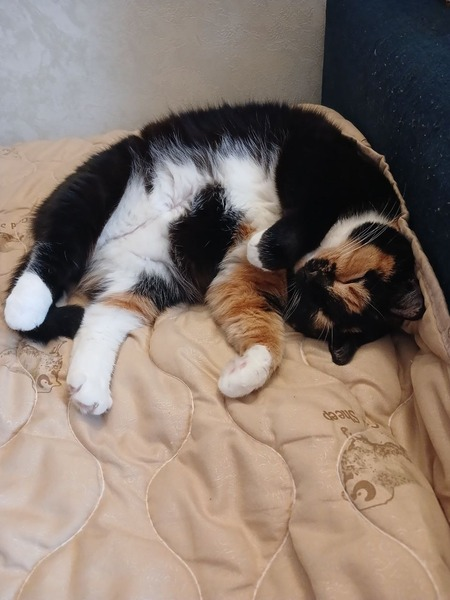

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Домашнее задание было очень полезным и познавательным. Оно позволило глубже понять, как работают DecisionTree, и научиться интерпретировать их предсказания с помощью таких инструментов, как SHAP и LIME

**Время выполнения**

На выполнение задания ушло около 3 дня, если суммировать часы по вечерам, включая изучение материалов, написание кода и отладку